## Project Three: Three Body System

Initial Condition
    1. Two Stationary Stars and One Body Introduced
        init_state: Star1_p = (-100, 0) v = (0, 0)
                    Star2_p = (100, 0)  v = (0, 0)
                    Planet_p = (50, 50) v = (0, -50) 
                    
        
    2. Two Stationary Stars and Two Bodies Introduced with pretty much the same condition(chaos)
    
    3. Binary Star System with Two Bodies Introduced
    
    Mass of Sun: 2 * 10^30 kg (2 kg)
    Mass of Earth: 6 * 10^24 kg (.02kg)
    G constant: 6.67*10^-11
    
   
    binary star orbits: https://en.wikipedia.org/wiki/Habitability_of_binary_star_systems
    wired article: https://www.wired.com/2016/06/way-solve-three-body-problem/
    

In [1]:
%matplotlib notebook
from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

In [3]:
condition = Condition(#m_s1 = 2,
                      m_s1 = 2 * 10**6,
                      m_s2 = 2 * 10**6,
                      m_p1 = 6,
                      G = 6.67*10**-2,
                    #726 max run time without collision correction
                      duration = 5000,
                    #Minimun dt of 0.001 to be accurate
                      dt = 0.001)

In [4]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # make the initial state
    init = State(x_s1=-100, y_s1=0, x_s2=100, y_s2=0, x_p1=50, y_p1=50, vx_s1=0, vy_s1=0, vx_s2=0, vy_s2=0, vx_p1=0, vy_p1=-65)
    
    # compute timestamps
    ts = linrange(0, duration, dt)
    
    return System(init=init, G = G, m_s1 = m_s1, m_s2 = m_s2, m_p1 = m_p1, ts=ts, dt_delta = dt, m_pnew = 0, nevermores1 = 0, nevermores2 = 0)

In [5]:
system = make_system(condition)

In [6]:
def slope_func_1(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1 = state
    unpack(system)
    
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)
    
    distance_p1s1 = pos_s1 - pos_p1
    distance_p1s2 = pos_s2 - pos_p1
    
    F_p1s1 = (G * m_s1 * m_p1 / (distance_p1s1.mag**2)) * distance_p1s1.hat()
    F_p1s2 = (G * m_s2 * m_p1 / (distance_p1s2.mag**2)) * distance_p1s2.hat()
    
    a_p1s1 = F_p1s1 / m_p1
    a_p1s2 = F_p1s2 / m_p1
    a = a_p1s1 + a_p1s2
    #print(a)
    a = Vector(a)
    #print(type(a))
    
    p_present = v_p1 * m_p1
    p_p1s1 = F_p1s1 * dt_delta
    p_p1s2 = F_p1s2 * dt_delta
    p_total = p_present+p_p1s1+p_p1s2
    
    v_p1 = p_total / m_p1
    v_p1 = Vector(v_p1)
    
    #Use positions to find force acting on the planet, use the force to find momentum and acceleration, and then 
    #velocity from momentum. Return velocity and acceleration.
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, 0, 0, 0, 0, a.x, a.y

In [7]:
slope_func_1(system.init, 0, system)

(0,
 0,
 0,
 0,
 <Quantity(0.013803434843659547, 'dimensionless')>,
 <Quantity(-65.02055300028152, 'dimensionless')>,
 0,
 0,
 0,
 0,
 <Quantity(13.803434843659549, 'dimensionless')>,
 <Quantity(-20.553000281522934, 'dimensionless')>)

In [8]:
def slope_func_inelastic(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1 = state
    unpack(system)
    m_pnew = system.m_pnew
    nevermores1 = system.nevermores1
    nevermores2 = system.nevermores2
    
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)
    
    if ((x_p1 - x_s1)**2 + (y_p1 - y_s1)**2) < (10**2) and nevermores1 == 0:
        print("collision between planet and sun1")
        distance_p1s1 = pos_s1 - pos_s1 #zero vector
        system.nevermores1 = 1
        print(distance_p1s1)
    else:
        distance_p1s1 = pos_s1 - pos_p1
        F_p1s1 = (G * m_s1 * (m_p1 + m_pnew) / (distance_p1s1.mag**2)) * distance_p1s1.hat()
        
    """
    if ((x_p1 - x_s1)**2 + (y_p1 - y_s1)**2) < (10**2):
        nevermores1 = 1
    else:
        nevermores1 = 0
    #if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (10**2) and nevermores2 == 0:
    if nevermores1 == 1:
        print("collision between planet and sun2")
        system.nevermores1 = 1
        v_p1 = v_p1 * (m_p1 / (m_p1 + m_s1))
        system.m_pnew  = m_s1
        F_p1s1 = Vector(0,0)
    else:
        if nevermores1 == 0:
            distance_p1s1 = pos_s1 - pos_p1
            F_p1s1 = (G * m_s1 * (m_p1 + m_pnew) / (distance_p1s1.mag**2)) * distance_p1s1.hat()
        else:
            F_p1s1 = Vector(0,0)
    """
        
    """
    The first IF below this comment checks the distance between the planet and the sun based on Cassandra's original
    IF statement, and it toggles nevermores2 accordingly.
    
    The second IF would then act depending on whether or not nevermore2 is true.
    """
    if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (10**2):
        nevermores2 = 1
    else:
        nevermores2 = 0
    #if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (10**2) and nevermores2 == 0:
    if nevermores2 == 1:
        print("collision between planet and sun2")
        system.nevermores2 = 1
        v_p1 = v_p1 * (m_p1 / (m_p1 + m_s2))
        system.m_pnew  = m_s2
        F_p1s2 = Vector(0,0)
    else:
        if nevermores2 == 0:
            distance_p1s2 = pos_s2 - pos_p1
            F_p1s2 = (G * m_s2 * (m_p1 + m_pnew) / (distance_p1s2.mag**2)) * distance_p1s2.hat()
        else:
            F_p1s2 = Vector(0,0)
    
    a_p1s1 = F_p1s1 / (m_p1 + m_pnew)
    a_p1s2 = F_p1s2 / (m_p1 + m_pnew)
    a = a_p1s1 + a_p1s2
    #print(a)
    a = Vector(a)
    #print(type(a))
    
    p_present = v_p1 * (m_p1 + m_pnew)
    p_p1s1 = F_p1s1 * dt_delta
    p_p1s2 = F_p1s2 * dt_delta
    p_total = p_present+p_p1s1+p_p1s2
    
    v_p1 = p_total / (m_p1 + m_pnew)
    v_p1 = Vector(v_p1)
    
    print(v_p1)
    
    #Use positions to find force acting on the planet, use the force to find momentum and acceleration, and then 
    #velocity from momentum. Return velocity and acceleration.
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, 0, 0, 0, 0, a.x, a.y

In [9]:
slope_func_inelastic(system.init, 0, system)

[  1.38034348e-02  -6.50205530e+01] dimensionless


(0,
 0,
 0,
 0,
 <Quantity(0.013803434843659547, 'dimensionless')>,
 <Quantity(-65.02055300028152, 'dimensionless')>,
 0,
 0,
 0,
 0,
 <Quantity(13.803434843659549, 'dimensionless')>,
 <Quantity(-20.553000281522934, 'dimensionless')>)

In [10]:
system = make_system(condition)
run_odeint(system, slope_func_1)

C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [11]:
system = make_system(condition)
%time run_odeint(system, slope_func_inelastic)

[  1.38034348e-02  -6.50205530e+01] dimensionless
[  1.38034348e-02  -6.50205530e+01] dimensionless
[  1.38051239e-02  -6.50205555e+01] dimensionless
[  1.38051239e-02  -6.50205555e+01] dimensionless
[  1.38068130e-02  -6.50205580e+01] dimensionless
[  1.38068130e-02  -6.50205580e+01] dimensionless
[  2.61994918e-02  -6.50389571e+01] dimensionless
[  2.61995075e-02  -6.50389571e+01] dimensionless
[  3.86201722e-02  -6.50573648e+01] dimensionless
[  3.86202036e-02  -6.50573648e+01] dimensionless
[  5.10689329e-02  -6.50757811e+01] dimensionless
[  5.10689643e-02  -6.50757811e+01] dimensionless
[  0.11548168 -65.17054783] dimensionless
[  0.11548204 -65.17054776] dimensionless
[  0.09452468 -65.13981066] dimensionless
[  0.09452484 -65.13981063] dimensionless
[  5.97329089e-02  -6.50885787e+01] dimensionless
[  5.97329153e-02  -6.50885787e+01] dimensionless
[  0.06841047 -65.10138054] dimensionless
[  0.06841046 -65.10138054] dimensionless
[  0.07710162 -65.11418646] dimensionless
[  0.0

[ 50.52833261 -11.83892591] dimensionless
[ 49.7969321  -10.96520147] dimensionless
[ 49.79693171 -10.96520118] dimensionless
[ 49.08240745 -10.15092783] dimensionless
[ 49.08240637 -10.15092712] dimensionless
[ 48.3849856   -9.39050379] dimensionless
[ 48.3849848   -9.39050342] dimensionless
[ 47.70467383  -8.67897111] dimensionless
[ 47.70467316  -8.67897089] dimensionless
[ 47.04131449  -8.01192948] dimensionless
[ 47.041314    -8.01192939] dimensionless
[ 46.39463122  -7.38546675] dimensionless
[ 46.39463085  -7.38546672] dimensionless
[ 45.76426258  -6.79609694] dimensionless
[ 45.7642623   -6.79609695] dimensionless
[ 45.14978821  -6.24070705] dimensionless
[ 45.149788    -6.24070708] dimensionless
[ 44.27830242  -5.48351118] dimensionless
[ 44.27830174  -5.48351134] dimensionless
[ 43.43834095  -4.78551507] dimensionless
[ 43.43833842  -4.78551573] dimensionless
[ 42.62833672  -4.14016163] dimensionless
[ 42.62833461  -4.1401624 ] dimensionless
[ 41.84673523  -3.54180558] dimens

[  1.09203214  57.34137627] dimensionless
[  1.09203208  57.34137622] dimensionless
[  1.1715385   56.64955712] dimensionless
[  1.17153843  56.64955713] dimensionless
[  1.24294933  55.954136  ] dimensionless
[  1.24294927  55.95413609] dimensionless
[  1.30691413  55.25807368] dimensionless
[  1.30691425  55.25807384] dimensionless
[  1.36405878  54.56389601] dimensionless
[  1.3640589   54.56389614] dimensionless
[  1.41497722  53.8737326 ] dimensionless
[  1.4149773   53.87373265] dimensionless
[  1.46022744  53.18935749] dimensionless
[  1.46022746  53.18935748] dimensionless
[  1.50032892  52.51222945] dimensionless
[  1.50032893  52.51222942] dimensionless
[  1.53576195  51.84353059] dimensionless
[  1.53576196  51.84353056] dimensionless
[  1.56696793  51.18420239] dimensionless
[  1.56696793  51.18420235] dimensionless
[  1.61202673  50.07082074] dimensionless
[  1.61202672  50.07082044] dimensionless
[  1.64751735  48.99001839] dimensionless
[  1.64751721  48.99001626] dimens

[-0.00563933  0.00075099] dimensionless
[-749.49608395  195.71552589] dimensionless
collision between planet and sun2
[-0.00563933  0.00075099] dimensionless
collision between planet and sun2
[-0.00563933  0.00075099] dimensionless
collision between planet and sun2
[-0.00563933  0.00075099] dimensionless
[-749.49608395  195.71552589] dimensionless
collision between planet and sun2
[-0.00563933  0.00075099] dimensionless
[-749.49608395  195.71552589] dimensionless
[-749.49608394  195.71552589] dimensionless
collision between planet and sun2
[-0.00563933  0.00075099] dimensionless
[-749.49608394  195.71552589] dimensionless
collision between planet and sun2
[-0.00563933  0.00075099] dimensionless
[-749.49608394  195.71552589] dimensionless
collision between planet and sun2
[-0.00563933  0.00075099] dimensionless
[-749.49608395  195.71552589] dimensionless
collision between planet and sun2
[-0.00563933  0.00075099] dimensionless
[-749.49608395  195.71552589] dimensionless
collision betwee

collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563938  0.000751  ] dimensionless
collision between planet and sun2
[-0.

[-0.00563943  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
[-749.52566795  195.71709665] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563943  0.000751  ] dimensionless
[-749.52566902  195.71709363] dimensionless
collision between planet and sun2
[-0.00563942  0.000751  

[-0.00563947  0.000751  ] dimensionless
[-749.53931268  195.71781561] dimensionless
[-749.53931268  195.71781561] dimensionless
[-749.53931268  195.71781561] dimensionless
[-749.5393125   195.71781549] dimensionless
[-749.53931268  195.71781561] dimensionless
collision between planet and sun2
[-0.00563947  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563947  0.000751  ] dimensionless
[-749.53931268  195.71781561] dimensionless
[-749.53931268  195.71781561] dimensionless
[-749.53931268  195.71781561] dimensionless
[-749.53931268  195.71781561] dimensionless
[-749.5393015   195.71781561] dimensionless
[-749.53931268  195.7178185 ] dimensionless
collision between planet and sun2
[-0.00563947  0.000751  ] dimensionless
[-749.53931239  195.71781663] dimensionless
collision between planet and sun2
[-0.00563947  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563947  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563947  0.000751  ] di

[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionless
collision between planet and sun2
[-0.00563951  0.000751  ] dimensionles

collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.00563958  0.00075101] dimensionless
collision between planet and sun2
[-0.

[-0.00563962  0.00075101] dimensionless
collision between planet and sun2
[-0.00563962  0.00075101] dimensionless
collision between planet and sun2
[-0.00563962  0.00075101] dimensionless
collision between planet and sun2
[-0.00563962  0.00075101] dimensionless
collision between planet and sun2
[-0.00563962  0.00075101] dimensionless
collision between planet and sun2
[-0.00563962  0.00075101] dimensionless
collision between planet and sun2
[-0.00563962  0.00075101] dimensionless
collision between planet and sun2
[-0.00563962  0.00075101] dimensionless
collision between planet and sun2
[-0.00563962  0.00075101] dimensionless
[-749.59141146  195.72056785] dimensionless
[-749.59141146  195.72056785] dimensionless
[-749.59141146  195.72056785] dimensionless
[-749.59141129  195.72056773] dimensionless
[-749.59141146  195.72056785] dimensionless
[-749.59141163  195.72056796] dimensionless
[-749.59141145  195.72056789] dimensionless
[-749.59141146  195.72056785] dimensionless
[-749.59141146  

[-749.60584307  195.72133194] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
[-749.60226273  195.72116009] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet and sun2
[-0.00563967  0.00075101] dimensionless
collision between planet

[-749.62841914  195.72253838] dimensionless
[-749.62841914  195.72253838] dimensionless
[-749.62841914  195.72253838] dimensionless
[-749.62841914  195.72253838] dimensionless
[-749.62840796  195.72253838] dimensionless
[-749.62841914  195.72254128] dimensionless
collision between planet and sun2
[-0.00563975  0.00075101] dimensionless
collision between planet and sun2
[-0.00563975  0.00075101] dimensionless
collision between planet and sun2
[-0.00563975  0.00075101] dimensionless
collision between planet and sun2
[-0.00563975  0.00075101] dimensionless
collision between planet and sun2
[-0.00563975  0.00075101] dimensionless
collision between planet and sun2
[-0.00563975  0.00075101] dimensionless
collision between planet and sun2
[-0.00563975  0.00075101] dimensionless
collision between planet and sun2
[-0.00563975  0.00075101] dimensionless
collision between planet and sun2
[-0.00563975  0.00075101] dimensionless
collision between planet and sun2
[-0.00563975  0.00075101] dimensionl

collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensionless
[-749.64131488  195.72323232] dimensionless
collision between planet and sun2
[-0.00563979  0.00075102] dimensio

collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
[-749.66348996  195.72440505] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensionless
collision between planet and sun2
[-0.00563986  0.00075102] dimensio

collision between planet and sun2
[-0.00563992  0.00075102] dimensionless
[-749.68387041  195.72547887] dimensionless
[-749.68387041  195.72547887] dimensionless
[-749.68387041  195.72547887] dimensionless
[-749.68387024  195.72547876] dimensionless
[-749.68387041  195.72547887] dimensionless
collision between planet and sun2
[-0.00563992  0.00075102] dimensionless
collision between planet and sun2
[-0.00563992  0.00075102] dimensionless
[-749.68387041  195.72547887] dimensionless
[-749.68387041  195.72547887] dimensionless
[-749.68387041  195.72547887] dimensionless
[-749.68387041  195.72547887] dimensionless
[-749.68385924  195.72547887] dimensionless
[-749.68387041  195.72548177] dimensionless
collision between planet and sun2
[-0.00563992  0.00075102] dimensionless
collision between planet and sun2
[-0.00563992  0.00075102] dimensionless
collision between planet and sun2
[-0.00563992  0.00075102] dimensionless
collision between planet and sun2
[-0.00563992  0.00075102] dimensionles

collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensionless
[-749.71279206  195.7270123 ] dimensionless
collision between planet and sun2
[-0.00564001  0.00075103] dimensio

collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.00564004  0.00075103] dimensionless
collision between planet and sun2
[-0.

[-749.79822671  195.73154935] dimensionless
[-749.79822671  195.73154935] dimensionless
[-749.79822671  195.73154935] dimensionless
[-749.79822654  195.73154924] dimensionless
[-749.79822671  195.73154935] dimensionless
collision between planet and sun2
[-0.00564028  0.00075104] dimensionless
collision between planet and sun2
[-0.00564028  0.00075104] dimensionless
[-749.79822671  195.73154935] dimensionless
[-749.79822671  195.73154935] dimensionless
[-749.79822671  195.73154935] dimensionless
[-749.79822671  195.73154935] dimensionless
[-749.79821553  195.73154935] dimensionless
[-749.79822671  195.73155225] dimensionless
collision between planet and sun2
[-0.00564028  0.00075104] dimensionless
collision between planet and sun2
[-0.00564028  0.00075104] dimensionless
collision between planet and sun2
[-0.00564028  0.00075104] dimensionless
collision between planet and sun2
[-0.00564029  0.00075104] dimensionless
collision between planet and sun2
[-0.00564029  0.00075104] dimensionles

collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensionless
[-749.81507554  195.73244677] dimensionless
collision between planet and sun2
[-0.00564033  0.00075104] dimensio

[-749.84025815  195.73377743] dimensionless
[-749.84025832  195.73377754] dimensionless
collision between planet and sun2
[-0.00564041  0.00075105] dimensionless
collision between planet and sun2
[-0.00564041  0.00075105] dimensionless
[-749.84025832  195.73377754] dimensionless
[-749.84025832  195.73377754] dimensionless
[-749.84025832  195.73377754] dimensionless
[-749.84025832  195.73377754] dimensionless
[-749.84024715  195.73377754] dimensionless
[-749.84025832  195.73378044] dimensionless
collision between planet and sun2
[-0.00564041  0.00075105] dimensionless
collision between planet and sun2
[-0.00564041  0.00075105] dimensionless
collision between planet and sun2
[-0.00564042  0.00075105] dimensionless
collision between planet and sun2
[-0.00564042  0.00075105] dimensionless
collision between planet and sun2
[-0.00564042  0.00075105] dimensionless
collision between planet and sun2
[-0.00564042  0.00075105] dimensionless
collision between planet and sun2
[-0.00564042  0.000751

collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.00564046  0.00075105] dimensionless
collision between planet and sun2
[-0.

collision between planet and sun2
[-0.00564052  0.00075105] dimensionless
collision between planet and sun2
[-0.00564052  0.00075105] dimensionless
collision between planet and sun2
[-0.00564052  0.00075105] dimensionless
collision between planet and sun2
[-0.00564052  0.00075105] dimensionless
collision between planet and sun2
[-0.00564052  0.00075105] dimensionless
collision between planet and sun2
[-0.00564052  0.00075105] dimensionless
[-749.88115969  195.73593365] dimensionless
[-749.88115969  195.73593365] dimensionless
[-749.88115969  195.73593365] dimensionless
[-749.88115952  195.73593353] dimensionless
[-749.88115969  195.73593365] dimensionless
[-749.88115986  195.73593376] dimensionless
[-749.88115968  195.73593368] dimensionless
[-749.88115969  195.73593365] dimensionless
[-749.88115969  195.73593365] dimensionless
[-749.88115969  195.73593365] dimensionless
[-749.88115969  195.73593365] dimensionless
[-749.88114851  195.73593365] dimensionless
[-749.88115969  195.73593654

collision between planet and sun2
[-0.00564057  0.00075105] dimensionless
collision between planet and sun2
[-0.00564057  0.00075105] dimensionless
collision between planet and sun2
[-0.00564057  0.00075105] dimensionless
collision between planet and sun2
[-0.00564057  0.00075105] dimensionless
collision between planet and sun2
[-0.00564056  0.00075105] dimensionless
collision between planet and sun2
[-0.00564057  0.00075105] dimensionless
[-749.89111121  195.73647023] dimensionless
collision between planet and sun2
[-0.00564755  0.00075174] dimensionless
[-749.89111121  195.73647023] dimensionless
[-749.89111121  195.73647023] dimensionless
[-749.89111121  195.73647023] dimensionless
[-749.89111121  195.73647023] dimensionless
[-749.89111103  195.73647012] dimensionless
[-749.89111121  195.73647023] dimensionless
collision between planet and sun2
[-0.00564057  0.00075105] dimensionless
[-749.8911112   195.73647027] dimensionless
[-749.89111121  195.73647023] dimensionless
[-749.891111

[-0.00564064  0.00075106] dimensionless
[-749.91363846  195.73766951] dimensionless
collision between planet and sun2
[-0.00564064  0.00075106] dimensionless
collision between planet and sun2
[-0.00564064  0.00075106] dimensionless
collision between planet and sun2
[-0.00564064  0.00075106] dimensionless
collision between planet and sun2
[-0.00564064  0.00075106] dimensionless
collision between planet and sun2
[-0.00564064  0.00075106] dimensionless
collision between planet and sun2
[-0.00564064  0.00075106] dimensionless
collision between planet and sun2
[-0.00564064  0.00075106] dimensionless
collision between planet and sun2
[-0.00564064  0.00075106] dimensionless
collision between planet and sun2
[-0.00564064  0.00075106] dimensionless
collision between planet and sun2
[-0.00564064  0.00075106] dimensionless
[-749.91366186  195.73767077] dimensionless
[-749.91366186  195.73767077] dimensionless
[-749.91366186  195.73767077] dimensionless
[-749.91366168  195.73767065] dimensionless


[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionless
collision between planet and sun2
[-0.00564068  0.00075106] dimensionles

collision between planet and sun2
[-0.00564073  0.00075106] dimensionless
collision between planet and sun2
[-0.00564073  0.00075106] dimensionless
collision between planet and sun2
[-0.00564073  0.00075106] dimensionless
collision between planet and sun2
[-0.00564073  0.00075106] dimensionless
[-749.94232882  195.73919213] dimensionless
collision between planet and sun2
[-0.00564405  0.00075139] dimensionless
[-749.94232882  195.73919213] dimensionless
[-749.94232882  195.73919213] dimensionless
[-749.94232882  195.73919213] dimensionless
[-749.94232882  195.73919213] dimensionless
[-749.94232864  195.73919202] dimensionless
[-749.94232882  195.73919213] dimensionless
collision between planet and sun2
[-0.00564073  0.00075106] dimensionless
collision between planet and sun2
[-0.00564073  0.00075106] dimensionless
[-749.94232882  195.73919213] dimensionless
[-749.94232882  195.73919213] dimensionless
[-749.94232882  195.73919213] dimensionless
[-749.94232882  195.73919213] dimensionles

collision between planet and sun2
[-0.00564078  0.00075107] dimensionless
collision between planet and sun2
[-0.00564078  0.00075107] dimensionless
collision between planet and sun2
[-0.00564078  0.00075107] dimensionless
collision between planet and sun2
[-0.00564079  0.00075107] dimensionless
collision between planet and sun2
[-0.00564079  0.00075107] dimensionless
collision between planet and sun2
[-0.00564079  0.00075107] dimensionless
[-749.95995527  195.74013012] dimensionless
collision between planet and sun2
[-0.00564079  0.00075107] dimensionless
collision between planet and sun2
[-0.00564078  0.00075107] dimensionless
collision between planet and sun2
[-0.00564079  0.00075107] dimensionless
collision between planet and sun2
[-0.00564079  0.00075107] dimensionless
collision between planet and sun2
[-0.00564079  0.00075107] dimensionless
collision between planet and sun2
[-0.00564079  0.00075107] dimensionless
collision between planet and sun2
[-0.00564079  0.00075107] dimensio

[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
[-749.97756876  195.7410615 ] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and sun2
[-0.00564084  0.00075107] dimensionless
collision between planet and

collision between planet and sun2
[-0.00564091  0.00075107] dimensionless
collision between planet and sun2
[-0.00564091  0.00075107] dimensionless
collision between planet and sun2
[-0.00564091  0.00075107] dimensionless
collision between planet and sun2
[-0.00564091  0.00075107] dimensionless
collision between planet and sun2
[-0.00564091  0.00075107] dimensionless
[-750.00380661  195.74244389] dimensionless
[-750.00380661  195.74244389] dimensionless
[-750.00380661  195.74244389] dimensionless
[-750.00380644  195.74244378] dimensionless
[-750.00380661  195.74244389] dimensionless
collision between planet and sun2
[-0.00564092  0.00075107] dimensionless
[-750.0038066   195.74244393] dimensionless
[-750.00380661  195.74244389] dimensionless
[-750.00380661  195.74244389] dimensionless
[-750.00380661  195.74244389] dimensionless
[-750.00380661  195.74244389] dimensionless
[-750.00379543  195.74244389] dimensionless
[-750.00380661  195.74244679] dimensionless
[-750.00380735  195.74244132

collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.00564097  0.00075107] dimensionless
collision between planet and sun2
[-0.

collision between planet and sun2
[-0.00564118  0.00075109] dimensionless
collision between planet and sun2
[-0.00564118  0.00075109] dimensionless
[-750.08616772  195.74682939] dimensionless
[-750.08616772  195.74682939] dimensionless
[-750.08616772  195.74682939] dimensionless
[-750.08616772  195.74682939] dimensionless
[-750.08615654  195.74682939] dimensionless
[-750.08616772  195.74683229] dimensionless
collision between planet and sun2
[-0.00564118  0.00075109] dimensionless
collision between planet and sun2
[-0.00564118  0.00075109] dimensionless
collision between planet and sun2
[-0.00564118  0.00075109] dimensionless
collision between planet and sun2
[-0.00564118  0.00075109] dimensionless
collision between planet and sun2
[-0.00564118  0.00075109] dimensionless
collision between planet and sun2
[-0.00564118  0.00075109] dimensionless
collision between planet and sun2
[-0.00564118  0.00075109] dimensionless
collision between planet and sun2
[-0.00564118  0.00075109] dimensionl

collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
[-750.10723628  195.74794713] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensionless
collision between planet and sun2
[-0.00564125  0.00075109] dimensio

collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.00564146  0.0007511 ] dimensionless
collision between planet and sun2
[-0.

[-0.00564148  0.0007511 ] dimensionless
[-750.18065621  195.75185047] dimensionless
collision between planet and sun2
[-0.00564148  0.0007511 ] dimensionless
[-750.18065621  195.75185047] dimensionless
collision between planet and sun2
[-0.00564148  0.0007511 ] dimensionless
[-750.18065621  195.75185047] dimensionless
collision between planet and sun2
[-0.00564148  0.0007511 ] dimensionless
[-750.18065621  195.75185047] dimensionless
collision between planet and sun2
[-0.00564148  0.0007511 ] dimensionless
[-750.18065621  195.75185047] dimensionless
collision between planet and sun2
[-0.00564148  0.0007511 ] dimensionless
[-750.18065621  195.75185047] dimensionless
collision between planet and sun2
[-0.00564148  0.0007511 ] dimensionless
[-750.18065621  195.75185047] dimensionless
collision between planet and sun2
[-0.00564148  0.0007511 ] dimensionless
[-750.18065621  195.75185047] dimensionless
collision between planet and sun2
[-0.00564148  0.0007511 ] dimensionless
[-750.18065622  

C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


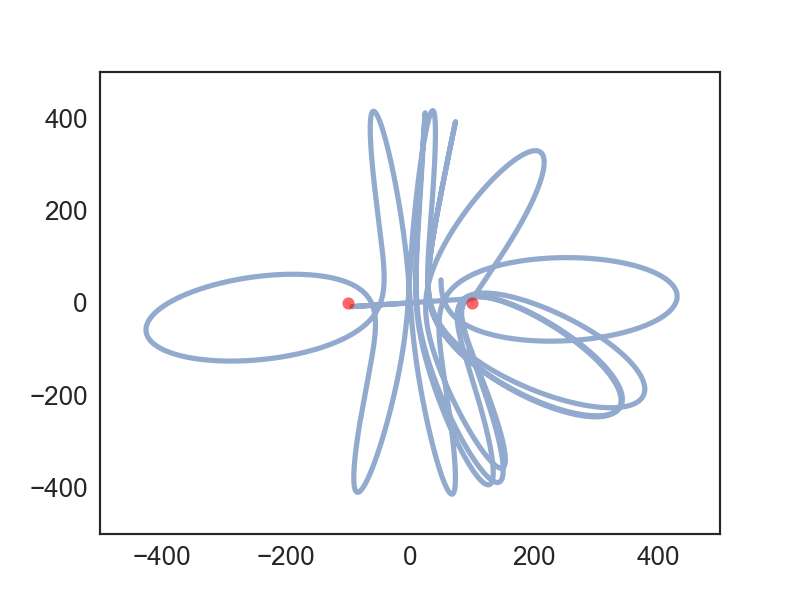

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [31]:
newfig()
plot(system.results.x_p1, system.results.y_p1)
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-500, 500],
         ylim = [-500, 500])

In [ ]:
type(system.results)

## Useful Stuff here?

In [36]:
#To make the animation faster
#The following line takes every 100th row of the original system.results
resampled = system.results.iloc[::5000, :]

<IPython.core.display.Javascript object>


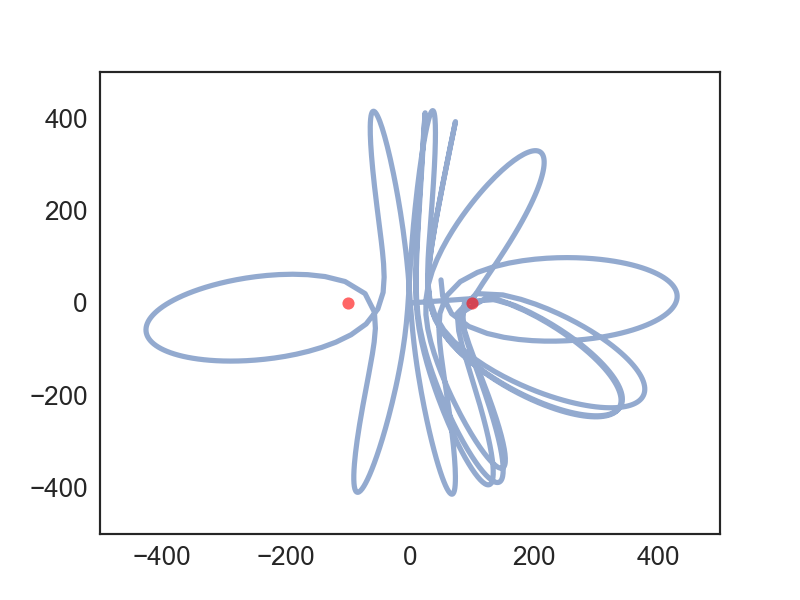

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [37]:
newfig()
plot(resampled.x_p1, resampled.y_p1)
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-500, 500],
         ylim = [-500, 500])

<IPython.core.display.Javascript object>


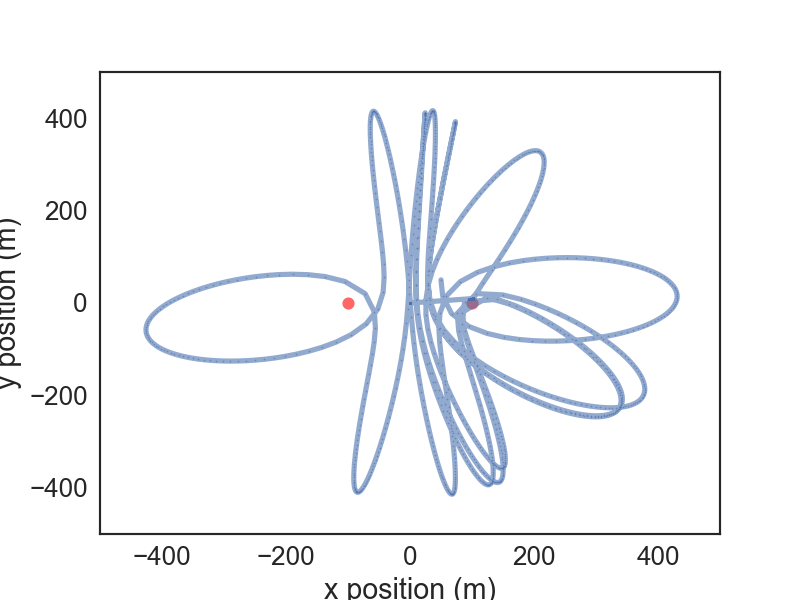

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

In [38]:
newfig()
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim = [-500, 500],
         ylim =[-500, 500],
         legend=False)
x_array = []
y_array = []
for x, y in zip(resampled.x_p1, resampled.y_p1):
    x_array.append(x)
    y_array.append(y)
    plot(x_array, y_array, '-o', markersize=1, update=True)
    #plot(x, y, '-o', update=True)
    #sleep(0.00001)